#### **Packages**

In [352]:
# Importing the required libraries
from datetime import datetime
import math
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
#OneHotEncoder is used when you have more than 2 categories (like places)
#LabelEncoder is used when you have only 2 categories (like gender)
#StandardScaler is to transform the data. This helps us to find optimize (find global minimum) faster.

#RandomForests work by training individuals decisions tree with randomized parameters and then averaging these results.
#Thanks to that, RandomForest are more resistant to overfitting. However, decision trees have a tendency to overfitting.
#They can pick up non-linear tendencies in the data
from xgboost import XGBRegressor, XGBClassifier, plot_importance

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 

%matplotlib inline 
#command that makes matplotlib plots appear inline within the notebook, directly below the code cells that produce them.

import warnings
warnings.filterwarnings('ignore')

In [353]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

#### Read file

In [354]:
df = pd.read_csv('Walmart.csv')

#### Basic Structure and Summary

In [355]:
df.drop(['Country'], axis=1, inplace=True)

In [356]:
list(df.columns)

['Order ID',
 'Order Date',
 'Ship Date',
 'Customer Name',
 'City',
 'State',
 'Category',
 'Product Name',
 'Sales',
 'Quantity',
 'Profit']

In [357]:
df.describe()

,Sales,Quantity,Profit
count,3203.000000,3203.000000,3203.000000
mean,226.493266,3.828910,33.849138
std,524.876911,2.260947,174.109155
min,0.990000,1.000000,-3399.980000
25%,19.440000,2.000000,3.850000
50%,60.840000,3.000000,11.170000
75%,215.810000,5.000000,33.000000
max,13999.960000,14.000000,6719.980000


In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       3203 non-null   object 
 1   Order Date     3203 non-null   object 
 2   Ship Date      3203 non-null   object 
 3   Customer Name  3203 non-null   object 
 4   City           3203 non-null   object 
 5   State          3203 non-null   object 
 6   Category       3203 non-null   object 
 7   Product Name   3203 non-null   object 
 8   Sales          3203 non-null   float64
 9   Quantity       3203 non-null   float64
 10  Profit         3203 non-null   float64
dtypes: float64(3), object(8)
memory usage: 275.4+ KB


In [359]:
df.isnull().sum()

Order ID         0
Order Date       0
Ship Date        0
Customer Name    0
City             0
State            0
Category         0
Product Name     0
Sales            0
Quantity         0
Profit           0
dtype: int64

In [360]:
df['Category'].unique()

array(['Labels', 'Furnishings', 'Art', 'Phones', 'Binders', 'Appliances',
       'Tables', 'Storage', 'Accessories', 'Paper', 'Chairs', 'Fasteners',
       'Supplies', 'Envelopes', 'Copiers', 'Bookcases', 'Machines'],
      dtype=object)

In [361]:
df['State'].unique()

array(['California', 'Washington', 'Utah', 'Arizona', 'Oregon',
       'Colorado', 'New Mexico', 'Nevada', 'Montana', 'Idaho', 'Wyoming'],
      dtype=object)

In [362]:
# Convert 'Order Date' and 'Ship Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [363]:
df

,Order ID,Order Date,Ship Date,Customer Name,City,State,Category,Product Name,Sales,Quantity,Profit
0,CA-2013-138688,2013-06-13,2013-06-17,Darrin Van Huff,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87
1,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17
2,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97
3,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72
4,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78
...,...,...,...,...,...,...,...,...,...,...,...
3198,CA-2013-125794,2013-09-30,2013-10-04,Maris LaWare,Los Angeles,California,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.24,1.0,15.22
3199,CA-2014-121258,2014-02-27,2014-03-04,Dave Brooks,Costa Mesa,California,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.96,2.0,15.63
3200,CA-2014-121258,2014-02-27,2014-03-04,Dave Brooks,Costa Mesa,California,Phones,Aastra 57i VoIP phone,258.58,2.0,19.39
3201,CA-2014-121258,2014-02-27,2014-03-04,Dave Brooks,Costa Mesa,California,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.60,4.0,13.32


#### **Exploratory Analysis and Visualization**

Perform exploratory analysis to uncover patterns, trends, and relationships in the data.

**a. Sales Trends Over Time**

<Axes: title={'center': 'Monthly Sales Over Time'}, xlabel='Order Date'>

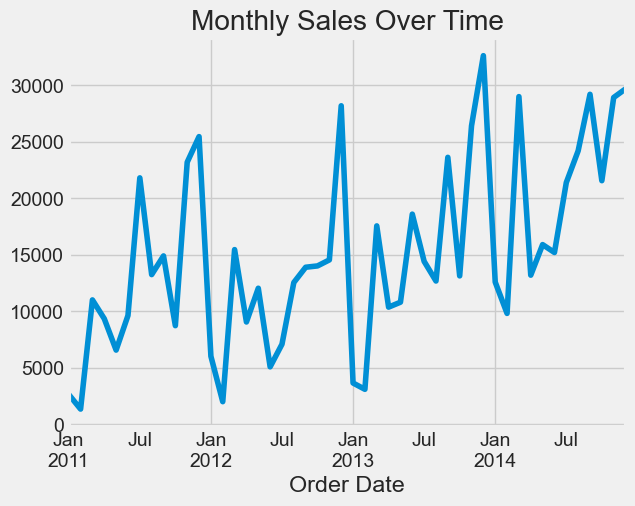

In [364]:
df.set_index('Order Date')['Sales'].resample('M').sum().plot(title='Monthly Sales Over Time')

**b. Category Analysis**

Explore sales, quantity, and profit by category:

In [365]:
def historical_product_plot(product_list):
    num_plots = len(product_list)
    num_rows = 9
    num_cols = 2
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 18))
    axs = axs.flatten()

    fig.suptitle('Historical Sales by Category', fontsize=18)

    for i, product_selected in enumerate(product_list):
        filter_tag = product_selected
        df_product = df[df['Category'] == filter_tag]
        pivot_product = pd.pivot_table(df_product, values='Sales', index='Order Date', aggfunc=np.sum)
        plot_row = math.floor(i / num_cols)
        plot_col = i % num_cols
        pivot_product.iloc[:len(pivot_product)-11].plot(title=product_selected, ax=axs[i])
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        axs[i].set_ylim(bottom=0)
        axs[i].grid(axis='y')
        axs[i].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # remove unused axes
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axs[i])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

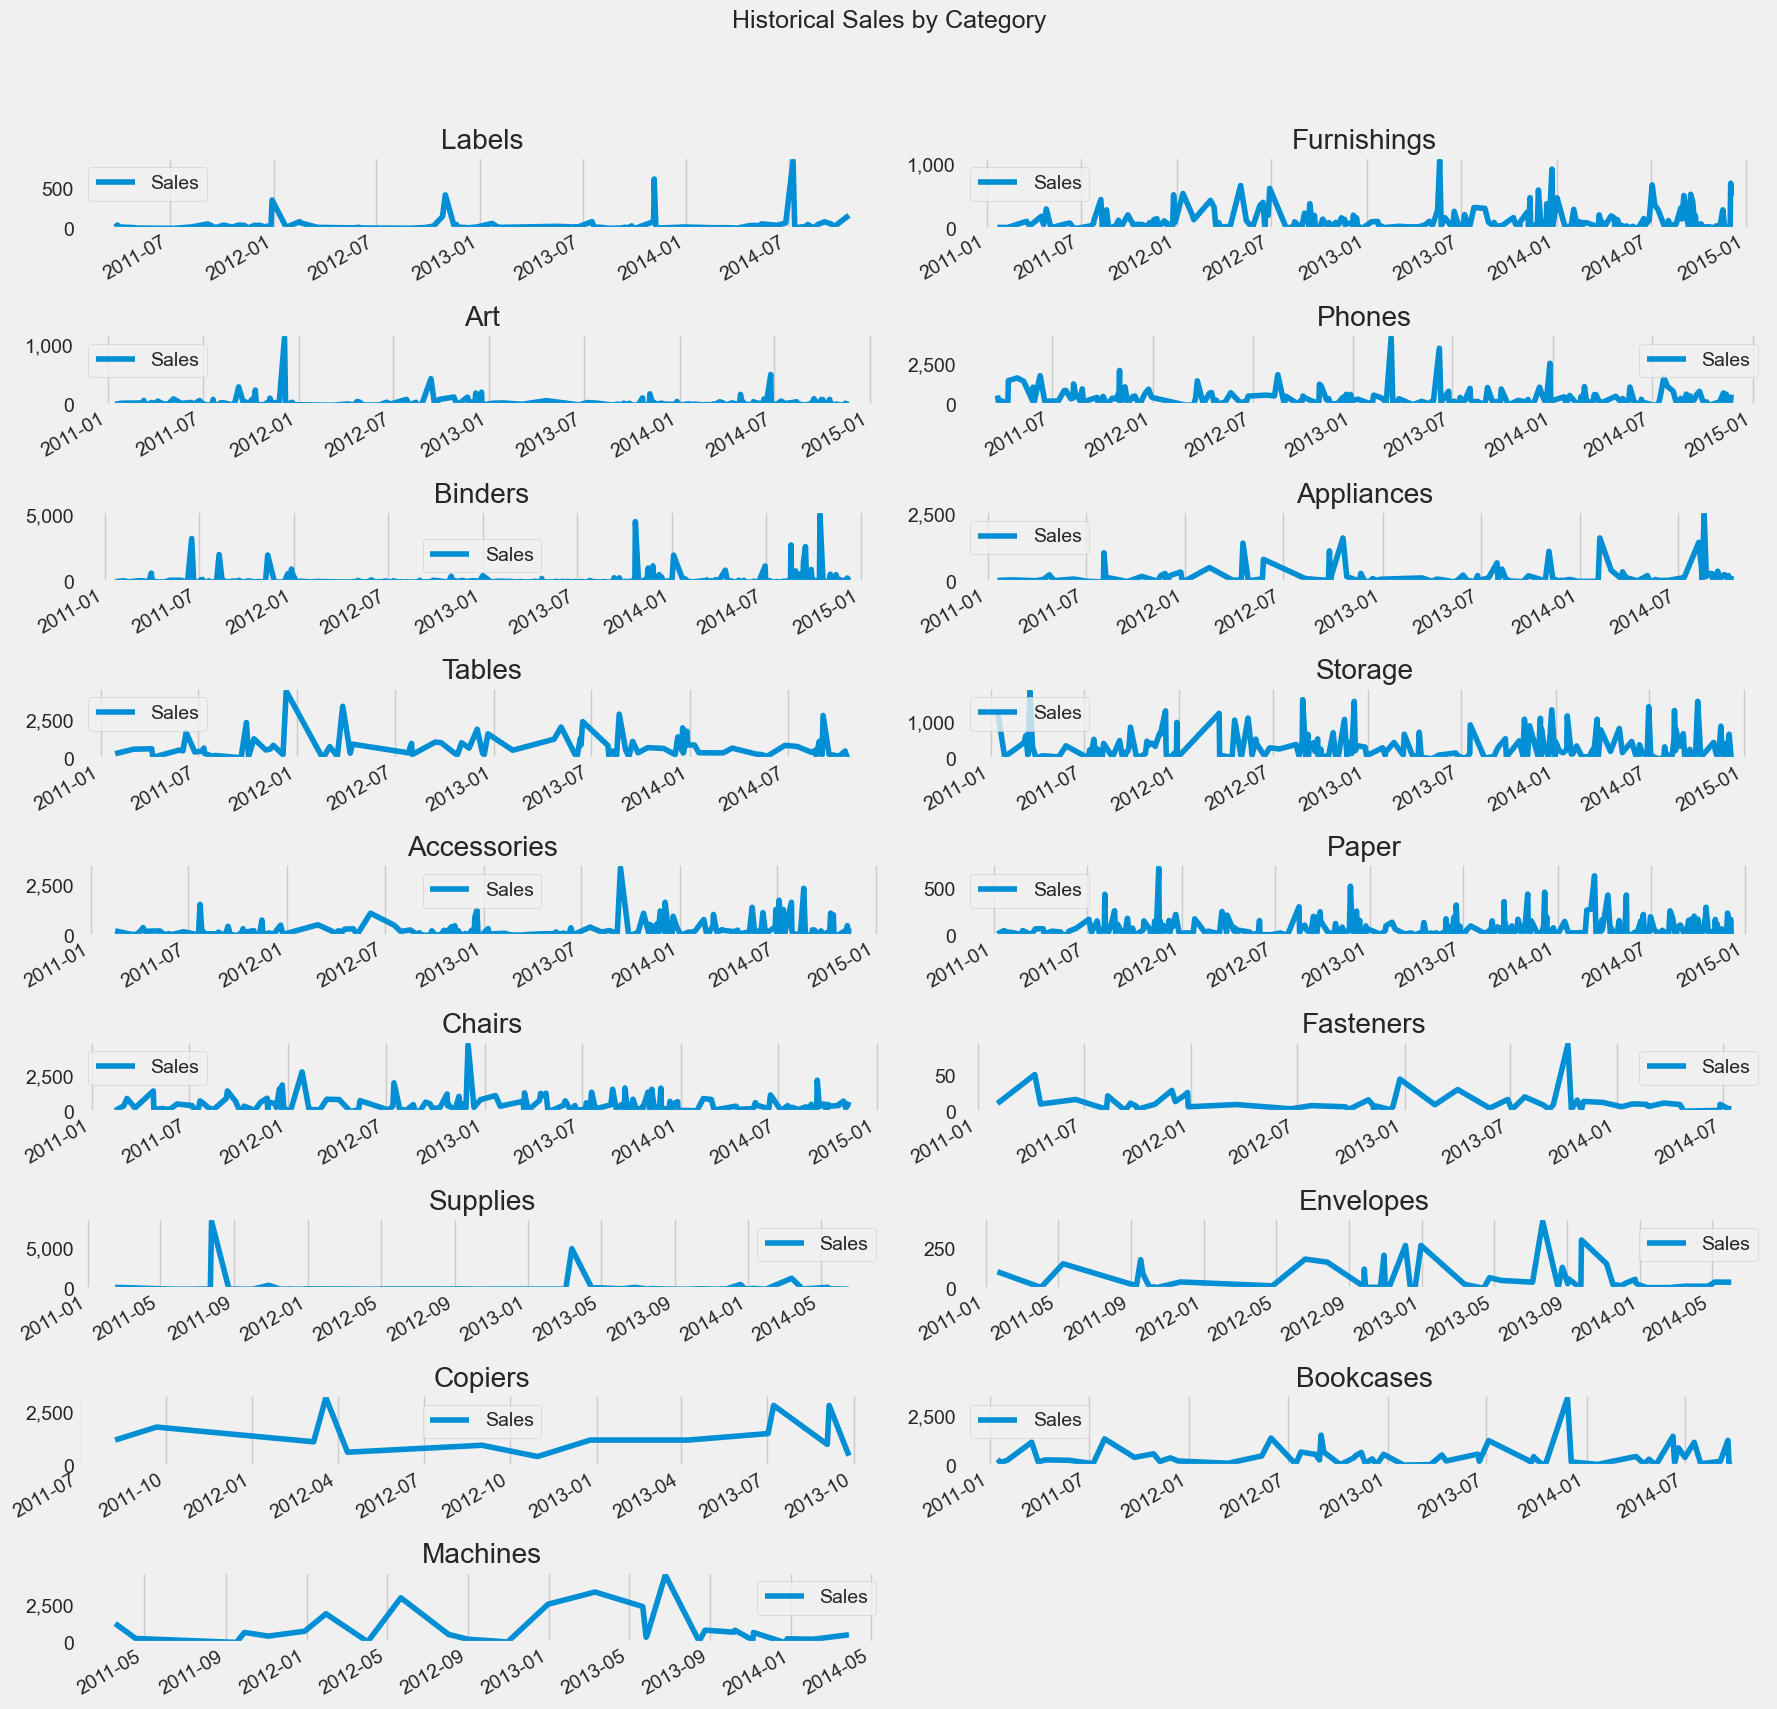

In [366]:
historical_product_plot(df['Category'].unique().tolist())

In [367]:
def category_size_plot(product_list):
    num_plots = len(product_list)
    num_rows = 6
    num_cols = 2
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 20), squeeze = False)
    axs = axs.flatten()

    # Adjust spacing between subplots, especially the vertical spacing
    fig.subplots_adjust(hspace=1.2)  # Increase the space between rows; adjust this value as needed
    
    fig.suptitle('Category size by State', fontsize=18)

    for i, product_selected in enumerate(product_list):
        filter_tag = product_selected
        df_product = df[df['State'] == filter_tag]
        pivot_product = pd.pivot_table(df_product, values=['Sales', 'Profit'], index='Category', aggfunc=np.sum)
        pivot_product_filtered = pivot_product[pivot_product['Sales'] > 0]
        sort_pivot_product = pivot_product_filtered.sort_values(by = "Profit", ascending = False)
        sort_pivot_product.plot(kind = "bar", title = f'Category size in {product_selected}', ax=axs[i])
        plot_row = math.floor(i / num_cols)
        plot_col = i % num_cols
        axs[i].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # remove unused axes
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axs[i])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

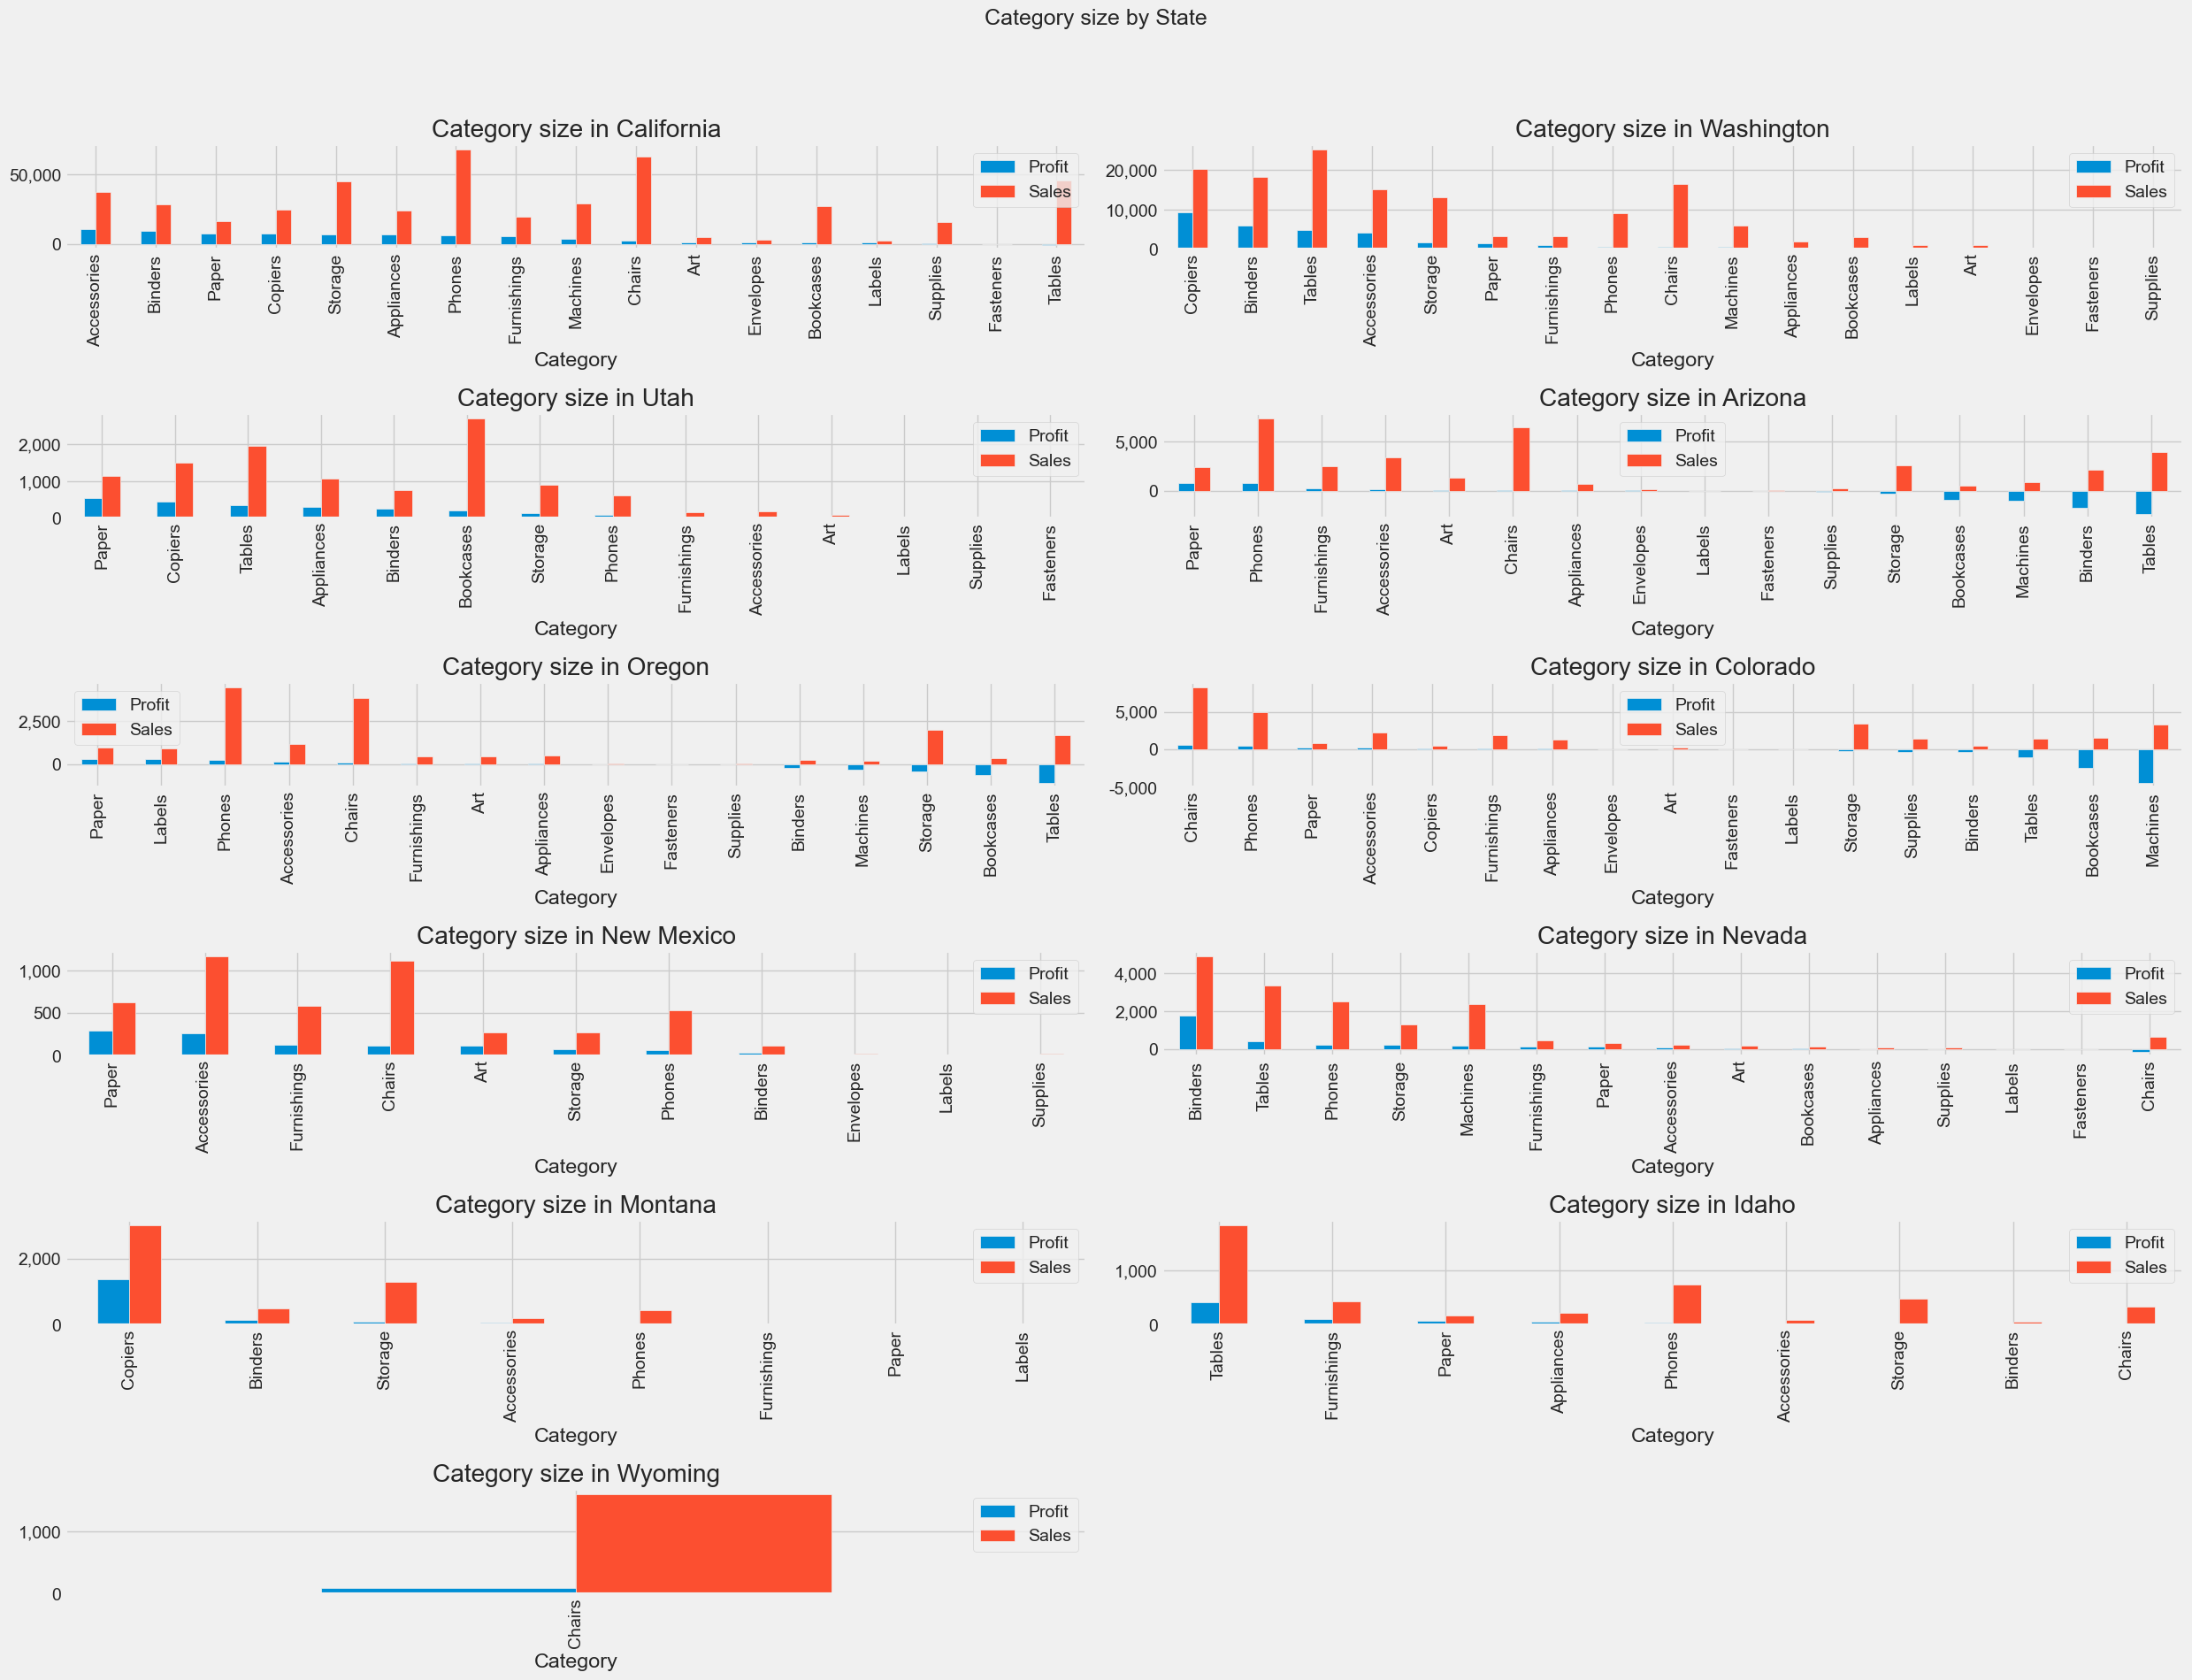

In [368]:
category_size_plot(df['State'].unique().tolist())

**c. Top Products and Customers**

Identify top products by sales and top customers:

In [369]:
# Top 10 products by sales
print(df.groupby('Product Name')['Sales'].sum().nlargest(10))

# Top 10 customers by number of orders
df['Customer Name'].value_counts().head(10)

Product Name
Canon imageCLASS 2200 Advanced Copier                                          13999.96
High Speed Automatic Electric Letter Opener                                    13100.24
Global Troy Executive Leather Low-Back Tilter                                  10019.61
Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind     8134.33
GuestStacker Chair with Chrome Finish Legs                                      8030.01
Okidata MB760 Printer                                                           7834.40
Bretford Rectangular Conference Table Tops                                      7710.66
Logitech P710e Mobile Speakerphone                                              7467.21
Canon PC1060 Personal Laser Copier                                              6719.90
Hewlett Packard LaserJet 3310 Copier                                            6239.89
Name: Sales, dtype: float64


Customer Name
William Brown       24
Arthur Prichep      23
Rick Wilson         19
Greg Guthrie        17
Zuschuss Carroll    16
Darrin Sayre        16
Sally Hughsby       15
Lena Creighton      15
Arianne Irving      15
Lena Cacioppo       15
Name: count, dtype: int64

**d. Geographic Analysis**

Analyze sales and profits by city or state:

In [370]:
filter_tag = 'Phones'
df_product = df[df['Category'] == filter_tag]
pivot_product = pd.pivot_table(df_product, values=['Sales', 'Product Name'], index='Order Date', aggfunc=np.sum)
pivot_product

,Product Name,Sales
Order Date,,
2011-03-23,Ooma Telo VoIP Home Phone System,604.75
2011-03-26,Griffin GC17055 Auxiliary Audio Cable,28.78
2011-03-28,AT&T TR1909W,302.38
2011-04-11,AT&T SB67148 SynJ,105.58
2011-04-12,Pyle PMP37LEDAT&T 1080 Corded phone,1513.46
...,...,...
2014-12-10,Nortel Business Series Terminal T7208 Digital ...,444.77
2014-12-11,Jackery Bar Premium Fast-charging Portable Cha...,95.84
2014-12-16,Panasonic KX TS3282B Corded phone,196.78


**e. Order Processing Time**

Calculate the processing time (difference between Ship Date and Order Date) and analyze its distribution:

In [371]:
df['Processing Time'] = (df['Ship Date'] - df['Order Date']).dt.days
df

,Order ID,Order Date,Ship Date,Customer Name,City,State,Category,Product Name,Sales,Quantity,Profit,Processing Time
0,CA-2013-138688,2013-06-13,2013-06-17,Darrin Van Huff,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87,4
1,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17,5
2,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97,5
3,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72,5
4,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3198,CA-2013-125794,2013-09-30,2013-10-04,Maris LaWare,Los Angeles,California,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.24,1.0,15.22,4
3199,CA-2014-121258,2014-02-27,2014-03-04,Dave Brooks,Costa Mesa,California,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.96,2.0,15.63,5
3200,CA-2014-121258,2014-02-27,2014-03-04,Dave Brooks,Costa Mesa,California,Phones,Aastra 57i VoIP phone,258.58,2.0,19.39,5
3201,CA-2014-121258,2014-02-27,2014-03-04,Dave Brooks,Costa Mesa,California,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.60,4.0,13.32,5


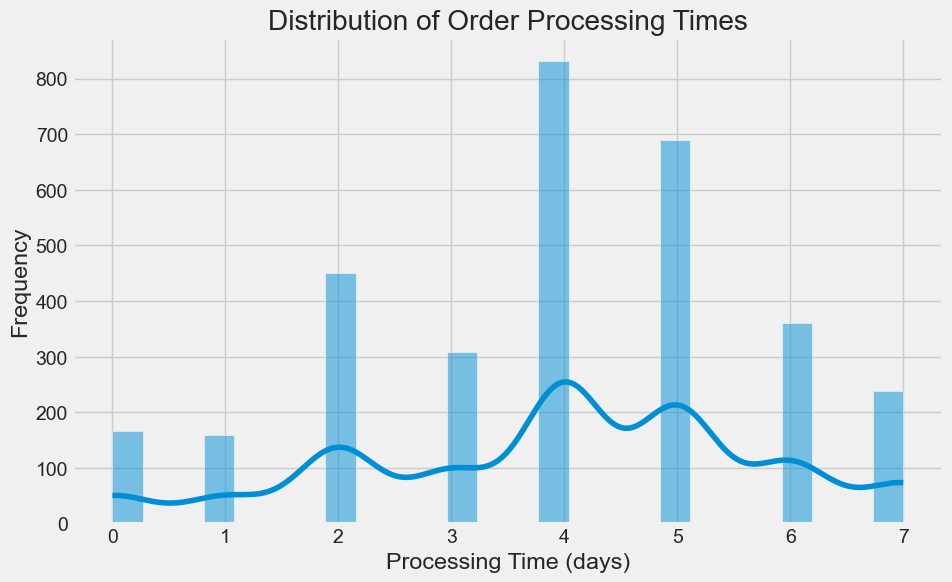

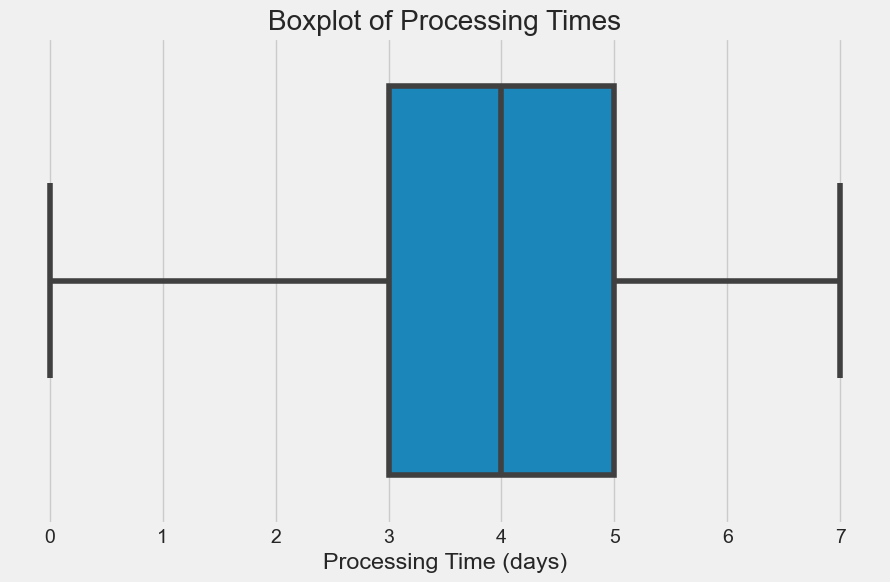

In [372]:
#Histogram of processing times
plt.figure(figsize=(10, 6))
sns.histplot(df['Processing Time'], kde=True)
plt.title('Distribution of Order Processing Times')
plt.xlabel('Processing Time (days)')
plt.ylabel('Frequency')
plt.show()
#qué es la linea?

# Boxplot to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Processing Time'])
plt.title('Boxplot of Processing Times')
plt.xlabel('Processing Time (days)')
plt.show()

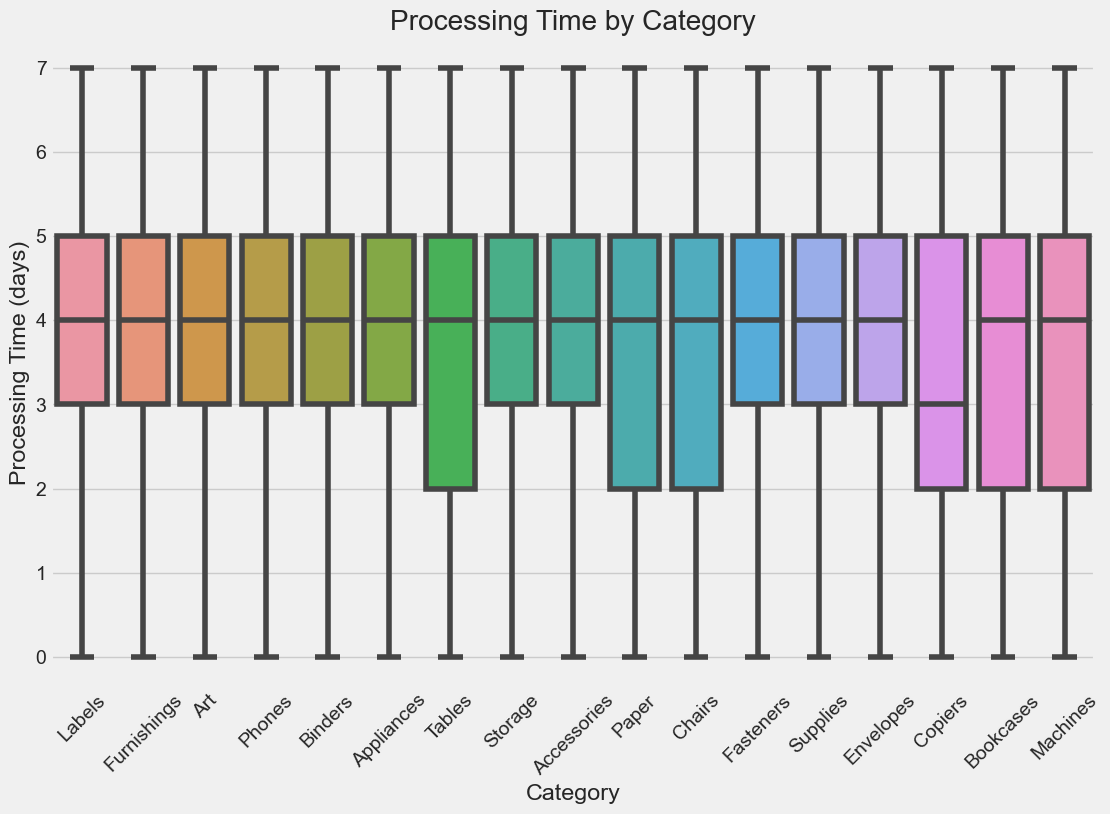

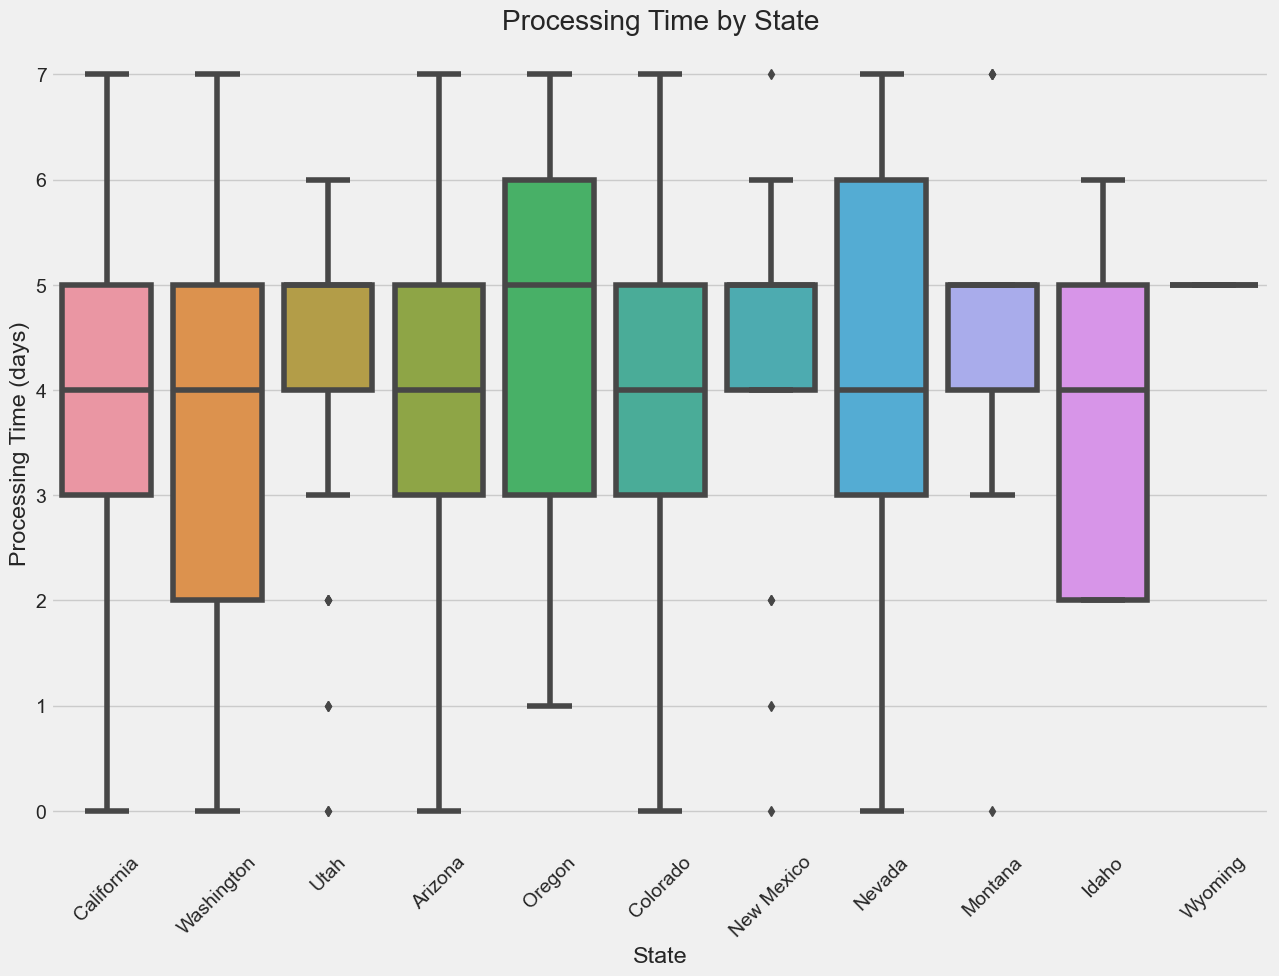

In [373]:
# Processing time by Category
plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='Processing Time', data=df)
plt.title('Processing Time by Category')
plt.xlabel('Category')
plt.ylabel('Processing Time (days)')
plt.xticks(rotation=45)  # Rotate labels if overlapping
plt.show()

# Processing time by State
plt.figure(figsize=(14, 10))
sns.boxplot(x='State', y='Processing Time', data=df)
plt.title('Processing Time by State')
plt.xlabel('State')
plt.ylabel('Processing Time (days)')
plt.xticks(rotation=45)  # Rotate labels if overlapping
plt.show()

In [374]:
average_processing_time_per_product = df.groupby('Product Name')['Processing Time'].mean()
average_processing_time_per_product

Product Name
"While you Were Out" Message Book, One Form per Page                                                   6.0
#10 Self-Seal White Envelopes                                                                          1.0
#10 White Business Envelopes,4 1/8 x 9 1/2                                                             5.0
#10- 4 1/8" x 9 1/2" Recycled Envelopes                                                                5.0
#10- 4 1/8" x 9 1/2" Security-Tint Envelopes                                                           2.8
                                                                                                      ... 
iKross Bluetooth Portable Keyboard + Cell Phone Stand Holder + Brush for Apple iPhone 5S 5C 5, 4S 4    5.5
iOttie HLCRIO102 Car Mount                                                                             3.5
iOttie XL Car Mount                                                                                    0.0
invisibleSHIELD by ZAGG 

In [375]:
# Define a function to apply the mode calculation for each group
def calculate_mode(group):
    # This returns the mode(s) of the group
    modes = group.value_counts().index[0]  # Take the first mode
    return modes
#The use of value_counts() ensures that the mode is determined based on the highest frequency of occurrence in each group, making it a robust choice for this operation.
# Group by 'Product Name' and apply the calculate_mode function to 'Processing Time'
mode_processing_time_per_product = df.groupby('Product Name')['Processing Time'].apply(calculate_mode)
mode_processing_time_per_product

Product Name
"While you Were Out" Message Book, One Form per Page                                                   6
#10 Self-Seal White Envelopes                                                                          1
#10 White Business Envelopes,4 1/8 x 9 1/2                                                             4
#10- 4 1/8" x 9 1/2" Recycled Envelopes                                                                6
#10- 4 1/8" x 9 1/2" Security-Tint Envelopes                                                           5
                                                                                                      ..
iKross Bluetooth Portable Keyboard + Cell Phone Stand Holder + Brush for Apple iPhone 5S 5C 5, 4S 4    7
iOttie HLCRIO102 Car Mount                                                                             2
iOttie XL Car Mount                                                                                    0
invisibleSHIELD by ZAGG Smudge-Free Screen

**f. Seasonality in Sales and Orders**

To detect seasonality, you'll want to plot sales and the number of orders over time at different granularities (daily, weekly, monthly, quarterly).

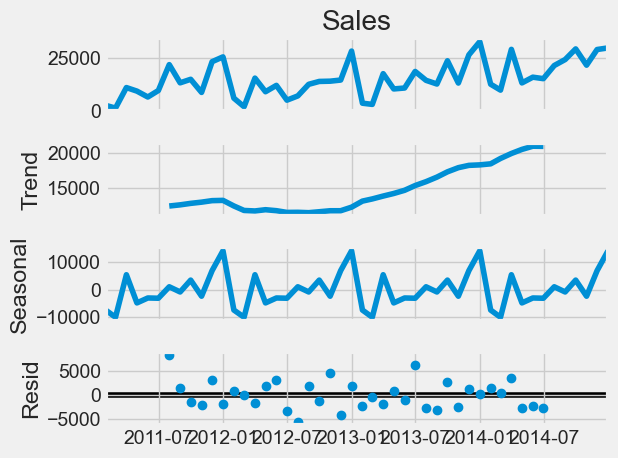

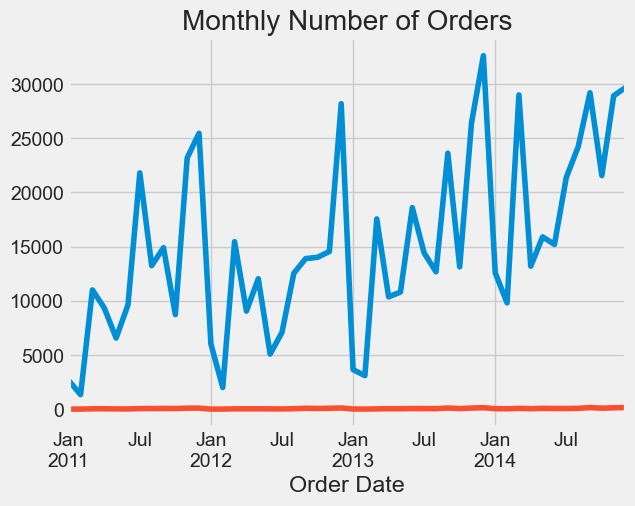

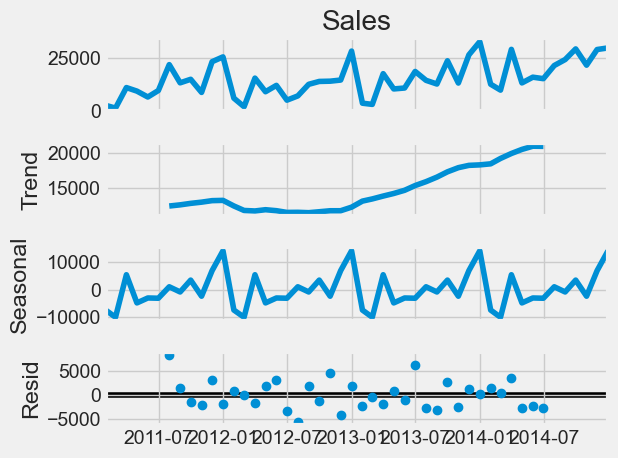

In [376]:
# Monthly Sales
df.set_index('Order Date')['Sales'].resample('M').sum().plot(title='Monthly Sales')

# Number of Orders per Month
df.set_index('Order Date')['Sales'].resample('M').count().plot(title='Monthly Number of Orders')

# For a more detailed seasonal decomposition:

result = seasonal_decompose(df.set_index('Order Date')['Sales'].resample('M').sum(), model='additive')
result.plot()

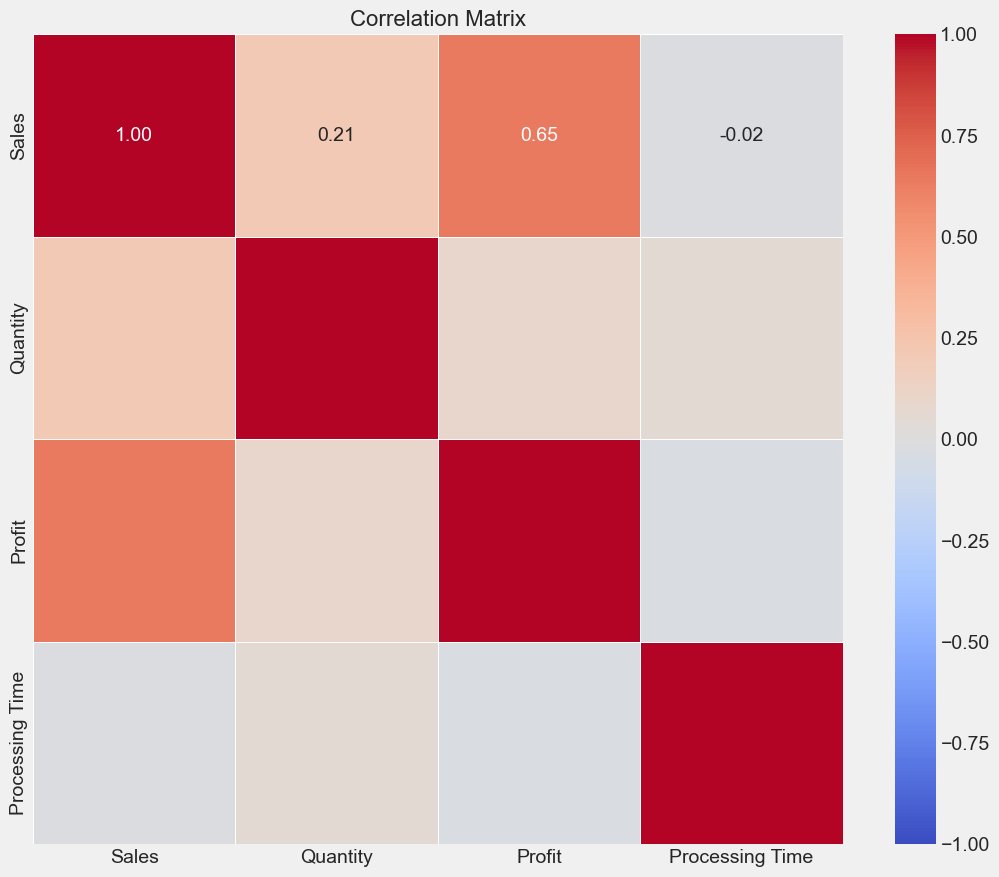

In [377]:
#HEATMAP
corr = df.drop(['Order ID',
 'Order Date',
 'Ship Date',
 'Customer Name',
 'City',
 'State',
 'Category',
 'Product Name'], axis=1).corr()
corr

plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix', fontsize=16)

sns.heatmap(corr, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, square=True)
plt.show()

### **Feature Engineering**

In [378]:
print(df['Processing Time'].value_counts())
print(df['City'].value_counts().nlargest(10))
df['State'].value_counts()

Processing Time
4    832
5    689
2    450
6    361
3    308
7    238
0    166
1    159
Name: count, dtype: int64
City
Los Angeles      747
San Francisco    510
Seattle          428
San Diego        170
Phoenix           63
Denver            44
San Jose          42
Springfield       38
Aurora            34
Tucson            32
Name: count, dtype: int64


State
California    2001
Washington     506
Arizona        224
Colorado       182
Oregon         124
Utah            53
Nevada          39
New Mexico      37
Idaho           21
Montana         15
Wyoming          1
Name: count, dtype: int64

In [379]:
condition = (df['State'] == 'Wyoming') | (df['State'] == 'Montana') | (df['State'] == 'Idaho') | (df['State'] == 'New Mexico') | (df['State'] == 'Nevada') | (df['State'] == 'Utah')
filtered_df = df[~condition]

In [380]:
condition = (filtered_df['City'] == 'Los Angeles') | (filtered_df['City'] == 'San Francisco') | (filtered_df['City'] == 'Seattle') | (filtered_df['City'] == 'San Diego') | (filtered_df['City'] == 'Phoenix') | (filtered_df['City'] == 'Denver') | (filtered_df['City'] == 'San Jose') | (filtered_df['City'] == 'Springfield') | (filtered_df['City'] == 'Aurora') | (filtered_df['City'] == 'Tucson') 
filtered_df = filtered_df[condition]

In [381]:
##Another useful feature could be the count of different categories included in each order. This indicates the diversity of products in each order, which might affect processing time.

# Count the number of unique categories per order
filtered_df['Unique_Categories_Per_Order'] = filtered_df.groupby('Order ID')['Category'].transform('nunique')

In [382]:
filtered_df

,Order ID,Order Date,Ship Date,Customer Name,City,State,Category,Product Name,Sales,Quantity,Profit,Processing Time,Unique_Categories_Per_Order
0,CA-2013-138688,2013-06-13,2013-06-17,Darrin Van Huff,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87,4,1
1,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17,5,6
2,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97,5,6
3,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72,5,6
4,CA-2011-115812,2011-06-09,2011-06-14,Brosina Hoffman,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,US-2013-103674,2013-12-07,2013-12-11,Anne Pryor,Los Angeles,California,Phones,Cisco SPA301,249.58,2.0,31.20,4,5
3195,US-2013-103674,2013-12-07,2013-12-11,Anne Pryor,Los Angeles,California,Fasteners,"Alliance Big Bands Rubber Bands, 12/Pack",13.86,7.0,0.00,4,5
3196,US-2013-103674,2013-12-07,2013-12-11,Anne Pryor,Los Angeles,California,Binders,Avery Durable Slant Ring Binders With Label Ho...,13.38,4.0,4.68,4,5
3197,US-2013-103674,2013-12-07,2013-12-11,Anne Pryor,Los Angeles,California,Binders,Ibico Recycled Linen-Style Covers,437.47,14.0,153.12,4,5


In [383]:
print(filtered_df['State'].value_counts())
filtered_df['City'].value_counts()

State
California    1469
Washington     428
Arizona         95
Colorado        78
Oregon          38
Name: count, dtype: int64


City
Los Angeles      747
San Francisco    510
Seattle          428
San Diego        170
Phoenix           63
Denver            44
San Jose          42
Springfield       38
Aurora            34
Tucson            32
Name: count, dtype: int64

___________________________________

In [384]:
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
categorical_columns = ['City', 'State', 'Category']  # adjust as needed
encoded_columns = encoder.fit_transform(filtered_df[categorical_columns])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Combine with numerical data
df_numeric = filtered_df[['Order ID', 'Processing Time','Sales', 'Quantity', 'Profit', 'Unique_Categories_Per_Order']]  # include any relevant numerical columns
df_processed = pd.concat([df_numeric.reset_index(drop=True), encoded_df], axis=1)

In [385]:
df_processed

,Order ID,Processing Time,Sales,Quantity,Profit,Unique_Categories_Per_Order,City_Denver,City_Los Angeles,City_Phoenix,City_San Diego,...,Category_Envelopes,Category_Fasteners,Category_Furnishings,Category_Labels,Category_Machines,Category_Paper,Category_Phones,Category_Storage,Category_Supplies,Category_Tables
0,CA-2013-138688,4,14.62,2.0,6.87,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CA-2011-115812,5,48.86,7.0,14.17,6,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CA-2011-115812,5,7.28,4.0,1.97,6,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CA-2011-115812,5,907.15,4.0,90.72,6,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CA-2011-115812,5,18.50,3.0,5.78,6,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103,US-2013-103674,4,249.58,2.0,31.20,5,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2104,US-2013-103674,4,13.86,7.0,0.00,5,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2105,US-2013-103674,4,13.38,4.0,4.68,5,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2106,US-2013-103674,4,437.47,14.0,153.12,5,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [386]:
order_size = df_processed.groupby('Order ID')[['Sales', 'Quantity', 'Profit']].sum().reset_index()
order_size.rename(columns={'Sales': 'Total Sales', 'Quantity': 'Total Quantity', 'Profit': 'Total Profit'}, inplace=True)
order_size

,Order ID,Total Sales,Total Quantity,Total Profit
0,CA-2011-100090,699.19,9.0,-19.09
1,CA-2011-101392,269.36,7.0,70.03
2,CA-2011-101462,59.92,4.0,27.56
3,CA-2011-101931,1252.60,17.0,18.62
4,CA-2011-102085,29.24,4.0,13.74
...,...,...,...,...
1053,US-2014-160143,29.70,3.0,8.02
1054,US-2014-163300,2911.78,17.0,895.62
1055,US-2014-163657,255.25,7.0,3.59
1056,US-2014-167318,2012.30,8.0,705.27


In [387]:
# Aggregate these category dummies at the 'Order ID' level
category_features = df_processed.groupby('Order ID')[['City_Denver',
                                                    'City_Los Angeles',
                                                    'City_Phoenix',
                                                    'City_San Diego',
                                                    'City_San Francisco',
                                                    'City_San Jose',
                                                    'City_Seattle',
                                                    'City_Springfield',
                                                    'City_Tucson',
                                                    'State_California',
                                                    'State_Colorado',
                                                    'State_Oregon',
                                                    'State_Washington',
                                                    'Category_Appliances',
                                                    'Category_Art',
                                                    'Category_Binders',
                                                    'Category_Bookcases',
                                                    'Category_Chairs',
                                                    'Category_Copiers',
                                                    'Category_Envelopes',
                                                    'Category_Fasteners',
                                                    'Category_Furnishings',
                                                    'Category_Labels',
                                                    'Category_Machines',
                                                    'Category_Paper',
                                                    'Category_Phones',
                                                    'Category_Storage',
                                                    'Category_Supplies',
                                                    'Category_Tables',
                                                    'Processing Time',
                                                    'Unique_Categories_Per_Order']].max().reset_index()

In [388]:
category_features

,Order ID,City_Denver,City_Los Angeles,City_Phoenix,City_San Diego,City_San Francisco,City_San Jose,City_Seattle,City_Springfield,City_Tucson,...,Category_Furnishings,Category_Labels,Category_Machines,Category_Paper,Category_Phones,Category_Storage,Category_Supplies,Category_Tables,Processing Time,Unique_Categories_Per_Order
0,CA-2011-100090,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,2
1,CA-2011-101392,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,1
2,CA-2011-101462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
3,CA-2011-101931,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3,4
4,CA-2011-102085,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,US-2014-160143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,1
1054,US-2014-163300,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,3
1055,US-2014-163657,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,2
1056,US-2014-167318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2


In [389]:
df_final = order_size.merge(category_features, on='Order ID', how='left')

In [390]:
def categorize_processing_time(days):
    if days <= 4:
        return 'Fast'
    else:
        return 'Slow'

df_final['Processing Time Category'] = df_final['Processing Time'].apply(categorize_processing_time)


In [391]:
# Convert categories to numerical format if not using one-hot encoding
df_final['Processing Time Category'] = df_final['Processing Time Category'].astype('category').cat.codes

,Order ID,Total Sales,Total Quantity,Total Profit,City_Denver,City_Los Angeles,City_Phoenix,City_San Diego,City_San Francisco,City_San Jose,...,Category_Labels,Category_Machines,Category_Paper,Category_Phones,Category_Storage,Category_Supplies,Category_Tables,Processing Time,Unique_Categories_Per_Order,Processing Time Category
0,CA-2011-100090,699.19,9.0,-19.09,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,2,0
1,CA-2011-101392,269.36,7.0,70.03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,1,1
2,CA-2011-101462,59.92,4.0,27.56,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,1
3,CA-2011-101931,1252.60,17.0,18.62,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3,4,0
4,CA-2011-102085,29.24,4.0,13.74,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,US-2014-160143,29.70,3.0,8.02,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,1,1
1054,US-2014-163300,2911.78,17.0,895.62,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,3,1
1055,US-2014-163657,255.25,7.0,3.59,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,2,0
1056,US-2014-167318,2012.30,8.0,705.27,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2,1


In [414]:
df_final[['City_Denver',
    'City_Los Angeles',
    'City_Phoenix',
    'City_San Diego',
    'City_San Francisco',
    'City_San Jose',
    'City_Seattle',
    'City_Springfield',
    'City_Tucson',
    'State_California',
    'State_Colorado',
    'State_Oregon',
    'State_Washington',
    'Category_Appliances',
    'Category_Art',
    'Category_Binders',
    'Category_Bookcases',
    'Category_Chairs',
    'Category_Copiers',
    'Category_Envelopes',
    'Category_Fasteners',
    'Category_Furnishings',
    'Category_Labels',
    'Category_Machines',
    'Category_Paper',
    'Category_Phones',
    'Category_Storage',
    'Category_Supplies',
    'Category_Tables',
    'Processing Time',
    'Unique_Categories_Per_Order']] = df_final[['City_Denver',
                                'City_Los Angeles',
                                'City_Phoenix',
                                'City_San Diego',
                                'City_San Francisco',
                                'City_San Jose',
                                'City_Seattle',
                                'City_Springfield',
                                'City_Tucson',
                                'State_California',
                                'State_Colorado',
                                'State_Oregon',
                                'State_Washington',
                                'Category_Appliances',
                                'Category_Art',
                                'Category_Binders',
                                'Category_Bookcases',
                                'Category_Chairs',
                                'Category_Copiers',
                                'Category_Envelopes',
                                'Category_Fasteners',
                                'Category_Furnishings',
                                'Category_Labels',
                                'Category_Machines',
                                'Category_Paper',
                                'Category_Phones',
                                'Category_Storage',
                                'Category_Supplies',
                                'Category_Tables',
                                'Processing Time',
                                'Unique_Categories_Per_Order']].round().astype('Int64')

In [415]:
df_final

,Order ID,Total Sales,Total Quantity,Total Profit,City_Denver,City_Los Angeles,City_Phoenix,City_San Diego,City_San Francisco,City_San Jose,...,Category_Labels,Category_Machines,Category_Paper,Category_Phones,Category_Storage,Category_Supplies,Category_Tables,Processing Time,Unique_Categories_Per_Order,Processing Time Category
0,CA-2011-100090,699.19,9.0,-19.09,0,0,0,0,1,0,...,0,0,0,0,0,0,1,4,2,0
1,CA-2011-101392,269.36,7.0,70.03,0,0,0,0,0,0,...,0,0,0,0,1,0,0,6,1,1
2,CA-2011-101462,59.92,4.0,27.56,0,1,0,0,0,0,...,0,0,0,0,0,0,0,5,1,1
3,CA-2011-101931,1252.60,17.0,18.62,0,1,0,0,0,0,...,0,0,0,0,1,1,0,3,4,0
4,CA-2011-102085,29.24,4.0,13.74,0,0,0,0,0,0,...,1,0,0,0,0,0,0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,US-2014-160143,29.70,3.0,8.02,0,1,0,0,0,0,...,0,0,0,0,0,1,0,7,1,1
1054,US-2014-163300,2911.78,17.0,895.62,0,1,0,0,0,0,...,0,0,0,1,0,0,0,6,3,1
1055,US-2014-163657,255.25,7.0,3.59,0,1,0,0,0,0,...,0,0,0,0,0,0,1,4,2,0
1056,US-2014-167318,2012.30,8.0,705.27,0,1,0,0,0,0,...,0,0,0,0,0,0,0,6,2,1


### **Model Development**

____________________________________________________________________________________

In [416]:
X = df_final.drop(['Processing Time', 'Order ID', 'Processing Time Category'], axis=1)
y = df_final['Processing Time Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [465]:
y.value_counts()

Processing Time Category
0    639
1    419
Name: count, dtype: int64

In [417]:
y_test

457    0
289    1
323    0
31     1
428    1
      ..
25     1
72     0
334    1
44     0
306    1
Name: Processing Time Category, Length: 212, dtype: int8

In [418]:
X_test

,Total Sales,Total Quantity,Total Profit,City_Denver,City_Los Angeles,City_Phoenix,City_San Diego,City_San Francisco,City_San Jose,City_Seattle,...,Category_Fasteners,Category_Furnishings,Category_Labels,Category_Machines,Category_Paper,Category_Phones,Category_Storage,Category_Supplies,Category_Tables,Unique_Categories_Per_Order
457,276.78,2.0,89.95,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
289,383.62,9.0,147.72,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,2
323,609.44,6.0,2.53,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
31,323.46,15.0,108.14,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,3
428,57.58,2.0,20.15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,20.04,6.0,8.82,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
72,8.56,2.0,3.85,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
334,568.86,20.0,94.60,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3
44,409.30,4.0,110.47,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,2


In [432]:
# Define the model
xgbR = XGBRegressor()

# Set up the parameter grid to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01],
    'n_estimators': [50, 100, 250, 500]

}

In [434]:
# Define the model
xgbC = XGBClassifier()

# Set up the parameter grid to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01],
    'n_estimators': [50, 100, 250, 500]
}

In [435]:
# Configure the GridSearchCV process
grid_search1 = GridSearchCV(estimator=xgbR, param_grid=param_grid, scoring='neg_mean_absolute_error')
grid_search2 = GridSearchCV(estimator=xgbC, param_grid=param_grid, scoring='accuracy')

In [436]:
# Fit GridSearchCV
grid_search1.fit(X, y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 250, 500]},
             scoring='neg_mean_absolute_error')

In [437]:
# Best parameters found
print("Best parameters:", grid_search1.best_params_)

# Best score
print("Best RMSE:", np.sqrt(-grid_search1.best_score_))

# Best estimator directly
best_xgbR = grid_search1.best_estimator_

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500}
Best RMSE: 0.6852414964386961


In [438]:
# Fit GridSearchCV
grid_search2.fit(X, y)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 250, 500]},
             scoring='accuracy')

In [439]:
# Best parameters found
print("Best parameters:", grid_search2.best_params_)

# Best score
print("Best RMSE:", np.sqrt(-grid_search2.best_score_))

# Best estimator directly
best_xgbC = grid_search2.best_estimator_

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Best RMSE: nan


In [441]:
# Alternatively, configure a new model with the best parameters
final_xgbR = XGBRegressor(**grid_search1.best_params_)
final_xgbR.fit(X_train, y_train)  # Fit the model on the entire dataset or split as appropriate

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [456]:
final_xgbC = XGBClassifier(**grid_search2.best_params_)
final_xgbC.fit(X_train, y_train)  # Fit the model on the entire dataset or split as appropriate

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [453]:
# Using the best estimator for predictions
predictions1 = final_xgbR.predict(X_test).round()  # Assuming you have a test set ready

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions1))
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, predictions1)
print(f"Mean Absolute Error: {mae}")

# Calculate MAE
mape = mean_absolute_percentage_error(y_test, predictions1)
print(f"Mean Absolute Percentage Error: {mape}")

# Calculate R-squared
r2 = r2_score(y_test, predictions1)
print(f"R-squared: {r2}")

precision_score(y_test, predictions1)

Root Mean Squared Error: 0.7104343771934509
Mean Absolute Error: 0.5047169923782349
Mean Absolute Percentage Error: 573571650655676.6
R-squared: -1.0450775333573747


0.34146341463414637

In [466]:
predictions1

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0

In [468]:
pd.DataFrame(predictions1).value_counts()

0.0    171
1.0     41
Name: count, dtype: int64

In [464]:
# Using the best estimator for predictions
predictions2 = final_xgbC.predict(X_test)  # Assuming you have a test set ready

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions2))
print(f"Root Mean Squared Error: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, predictions2)
print(f"Mean Absolute Error: {mae}")

# Calculate MAE
mape = mean_absolute_percentage_error(y_test, predictions2)
print(f"Mean Absolute Percentage Error: {mape}")

precision_score(y_test, predictions2)



Root Mean Squared Error: 0.6587581226451356
Mean Absolute Error: 0.4339622641509434
Mean Absolute Percentage Error: 21243394468729.184


0.75

In [459]:
predictions2


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [462]:
pd.DataFrame(y_test).value_counts(), pd.DataFrame(predictions2).value_counts()

(Processing Time Category
 0                           118
 1                            94
 Name: count, dtype: int64,
 0    208
 1      4
 Name: count, dtype: int64)

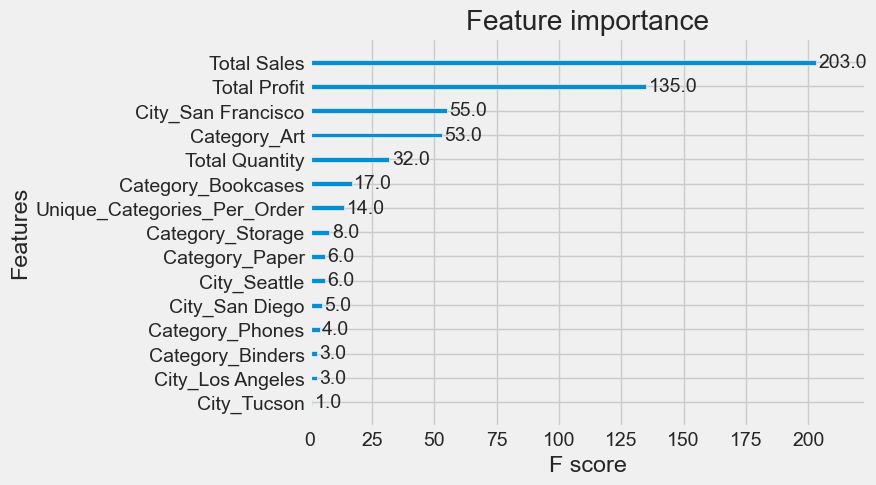

In [460]:
plot_importance(final_xgbC)
plt.show()